In [2]:
# Cell 1: Environment & imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import joblib
import math
import glob
import json

print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:
# Cell 2: Set up data directory

DATA_DIR = r'C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\backend\data'

# Check if files exist
train_file = os.path.join(DATA_DIR, 'train_FD003.txt')
test_file = os.path.join(DATA_DIR, 'test_FD003.txt')
rul_file = os.path.join(DATA_DIR, 'RUL_FD003.txt')

print(f"Train file exists: {os.path.exists(train_file)}")
print(f"Test file exists: {os.path.exists(test_file)}")
print(f"RUL file exists: {os.path.exists(rul_file)}")

Train file exists: True
Test file exists: True
RUL file exists: True


In [4]:
# Cell 3: Function to read CMAPSS text files (whitespace separated, no header)
def read_cmapss(filepath):
    """
    Read CMAPSS format: 26 columns whitespace separated
    columns: unit, cycle, op_setting_1..3, sensor_1..21
    """
    col_names = (["unit", "cycle",
                  "op_setting_1", "op_setting_2", "op_setting_3"] +
                 [f"s{i}" for i in range(1, 22)])
    df = pd.read_csv(filepath, sep=r"\s+", header=None, names=col_names)
    return df

# Read training data
df_train = read_cmapss(train_file)
print(f"Training data shape: {df_train.shape}")
print(f"Columns: {list(df_train.columns)}")
print(f"\nFirst few rows:")
print(df_train.head())

Training data shape: (24720, 26)
Columns: ['unit', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

First few rows:
   unit  cycle  op_setting_1  op_setting_2  op_setting_3      s1      s2  \
0     1      1       -0.0005        0.0004         100.0  518.67  642.36   
1     1      2        0.0008       -0.0003         100.0  518.67  642.50   
2     1      3       -0.0014       -0.0002         100.0  518.67  642.18   
3     1      4       -0.0020        0.0001         100.0  518.67  642.92   
4     1      5        0.0016        0.0000         100.0  518.67  641.68   

        s3       s4     s5  ...     s12      s13      s14     s15   s16  s17  \
0  1583.23  1396.84  14.62  ...  522.31  2388.01  8145.32  8.4246  0.03  391   
1  1584.69  1396.89  14.62  ...  522.42  2388.03  8152.85  8.4403  0.03  392   
2  1582.35  1405.61  14.62  ...  522.03 

In [5]:
# Cell 4: Create RUL (Remaining Useful Life) labels for training data
def add_rul_train(df):
    """
    For each unit, RUL = max_cycle_for_unit - current_cycle
    """
    df = df.copy()
    max_cycle = df.groupby("unit")["cycle"].max().reset_index()
    max_cycle.columns = ["unit", "max_cycle"]
    df = df.merge(max_cycle, on="unit", how="left")
    df["RUL"] = df["max_cycle"] - df["cycle"]
    df.drop("max_cycle", axis=1, inplace=True)
    return df

# Add RUL to training data
df_train = add_rul_train(df_train)
print(f"Training data with RUL shape: {df_train.shape}")
print(f"RUL statistics:")
print(df_train["RUL"].describe())
print(f"\nNumber of unique units: {df_train['unit'].nunique()}")

Training data with RUL shape: (24720, 27)
RUL statistics:
count    24720.000000
mean       138.077063
std         98.846675
min          0.000000
25%         61.000000
50%        123.000000
75%        190.000000
max        524.000000
Name: RUL, dtype: float64

Number of unique units: 100


In [6]:
# Cell 5: Data preprocessing - normalize sensors and cap RUL
def preprocess_df(df, cap_rul=125, scaler=None, fit_scaler=True):
    """
    Normalize sensor and operational setting columns.
    Cap RUL at a maximum value.
    """
    df = df.copy()
    
    # Auto-detect sensor and operational setting columns
    sensor_cols = [c for c in df.columns if c.startswith('s') or c.startswith('op_setting')]
    
    # Cap RUL
    df["RUL_capped"] = df["RUL"].clip(upper=cap_rul)
    
    # Fit scaler if not provided
    if scaler is None and fit_scaler:
        scaler = StandardScaler()
        scaler.fit(df[sensor_cols])
    
    # Apply scaling
    if scaler is not None:
        df[sensor_cols] = scaler.transform(df[sensor_cols])
    
    return df, scaler, sensor_cols

# Apply preprocessing
df_train_pre, scaler, sensor_cols = preprocess_df(df_train, cap_rul=125)
print(f"Sensor columns ({len(sensor_cols)}): {sensor_cols}")
print(f"Preprocessed data shape: {df_train_pre.shape}")
print(f"RUL_capped statistics:")
print(df_train_pre["RUL_capped"].describe())

Sensor columns (24): ['op_setting_1', 'op_setting_2', 'op_setting_3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
Preprocessed data shape: (24720, 28)
RUL_capped statistics:
count    24720.000000
mean        93.143204
std         40.627125
min          0.000000
25%         61.000000
50%        123.000000
75%        125.000000
max        125.000000
Name: RUL_capped, dtype: float64


In [7]:
# Cell 6: Create sequences for GRU model
def generate_sequences(df, seq_len=50, sensor_cols=None, label_col="RUL_capped", step=1):
    """
    Create sliding windows of sequences for each unit.
    Each sequence predicts RUL at the last timestep.
    """
    Xs = []
    ys = []
    units = sorted(df["unit"].unique())
    
    for u in units:
        tmp = df[df["unit"] == u].sort_values("cycle")
        data = tmp[sensor_cols].values
        labels = tmp[label_col].values
        n_cycles = data.shape[0]
        
        # Skip units with fewer cycles than sequence length
        if n_cycles < seq_len:
            continue
        
        # Create sliding windows
        for start in range(0, n_cycles - seq_len + 1, step):
            end = start + seq_len
            Xs.append(data[start:end])
            ys.append(labels[end - 1])
    
    X = np.array(Xs)
    y = np.array(ys)
    return X, y

# Generate sequences
SEQ_LEN = 50
X, y = generate_sequences(df_train_pre, seq_len=SEQ_LEN, sensor_cols=sensor_cols)
print(f"Sequences generated:")
print(f"X shape: {X.shape} (samples, sequence_length, features)")
print(f"y shape: {y.shape}")
print(f"y statistics: min={y.min():.2f}, max={y.max():.2f}, mean={y.mean():.2f}")

Sequences generated:
X shape: (19820, 50, 24) (samples, sequence_length, features)
y shape: (19820,)
y statistics: min=0.00, max=125.00, mean=85.36


In [8]:
# Cell 7: Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42, shuffle=True
)
print(f"Train set: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}")

Train set: X=(16847, 50, 24), y=(16847,)
Validation set: X=(2973, 50, 24), y=(2973,)


In [9]:
# Cell 8: Build GRU model
def build_gru_model(input_shape, units=64, dropout=0.2):
    """Build a GRU-based neural network for RUL prediction."""
    model = Sequential()
    model.add(GRU(units, input_shape=input_shape, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1, activation="linear"))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model

model = build_gru_model((SEQ_LEN, len(sensor_cols)), units=128, dropout=0.3)
print("Model created successfully!")
model.summary()

Model created successfully!


c:\Users\Sneha\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │        59,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,969 (265.50 KB)

 Trainable params: 67,713 (264.50 KB)

 Non-trainable params: 256 (1.00 KB)

In [11]:
# Cell 9: Train the model
EPOCHS = 60
BATCH_SIZE = 128

checkpoint_path = r'C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd003.h5'
scaler_path = r'C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\scaler_fd003.joblib'

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1)
]

print("Starting training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=2
)

# Save the scaler
joblib.dump(scaler, scaler_path)
print(f"Model saved to: {checkpoint_path}")
print(f"Scaler saved to: {scaler_path}")

Starting training...
Epoch 1/60

Epoch 1: val_loss improved from inf to 682.20300, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd003.h5


132/132 - 15s - 112ms/step - loss: 3438.7134 - mae: 46.3222 - val_loss: 682.2030 - val_mae: 18.1441
Epoch 2/60

Epoch 2: val_loss improved from 682.20300 to 392.28528, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd003.h5


132/132 - 11s - 82ms/step - loss: 507.3853 - mae: 17.4553 - val_loss: 392.2853 - val_mae: 13.8834
Epoch 3/60

Epoch 3: val_loss improved from 392.28528 to 222.37846, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd003.h5


132/132 - 11s - 86ms/step - loss: 351.9339 - mae: 14.5180 - val_loss: 222.3785 - val_mae: 10.8833
Epoch 4/60

Epoch 4: val_loss did not improve from 222.37846
132/132 - 10s - 77ms/step - loss: 284.3334 - mae: 13.1613 - val_loss: 291.9978 - val_mae: 12.7291
Epoch 5/60

Epoch 5: val_loss did not improve from 222.37846
132/132 - 11s - 83ms/step - loss: 357.7531 - mae: 14.6422 - val_loss: 473.9680 - val_mae: 17.6992
Epoch 6/60

Epoch 6: val_loss improved from 222.37846 to 141.59247, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd003.h5


132/132 - 11s - 83ms/step - loss: 287.2089 - mae: 13.1431 - val_loss: 141.5925 - val_mae: 8.9590
Epoch 7/60

Epoch 7: val_loss improved from 141.59247 to 127.66605, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd003.h5


132/132 - 11s - 84ms/step - loss: 227.8952 - mae: 11.5811 - val_loss: 127.6661 - val_mae: 8.1797
Epoch 8/60

Epoch 8: val_loss did not improve from 127.66605
132/132 - 10s - 79ms/step - loss: 218.1266 - mae: 11.3194 - val_loss: 144.6719 - val_mae: 8.9257
Epoch 9/60

Epoch 9: val_loss did not improve from 127.66605
132/132 - 11s - 80ms/step - loss: 222.1347 - mae: 11.4984 - val_loss: 200.0185 - val_mae: 10.8168
Epoch 10/60

Epoch 10: val_loss did not improve from 127.66605
132/132 - 10s - 79ms/step - loss: 220.9653 - mae: 11.4110 - val_loss: 149.7578 - val_mae: 9.4435
Epoch 11/60

Epoch 11: val_loss improved from 127.66605 to 120.94234, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd003.h5


132/132 - 11s - 82ms/step - loss: 198.9363 - mae: 10.7964 - val_loss: 120.9423 - val_mae: 7.8320
Epoch 12/60

Epoch 12: val_loss improved from 120.94234 to 113.79182, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd003.h5


132/132 - 11s - 81ms/step - loss: 205.4971 - mae: 11.0211 - val_loss: 113.7918 - val_mae: 7.7240
Epoch 13/60

Epoch 13: val_loss improved from 113.79182 to 108.96989, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd003.h5


132/132 - 11s - 80ms/step - loss: 195.5845 - mae: 10.7028 - val_loss: 108.9699 - val_mae: 7.6017
Epoch 14/60

Epoch 14: val_loss did not improve from 108.96989
132/132 - 10s - 79ms/step - loss: 183.9733 - mae: 10.3368 - val_loss: 116.7095 - val_mae: 8.1419
Epoch 15/60

Epoch 15: val_loss did not improve from 108.96989
132/132 - 11s - 80ms/step - loss: 192.6174 - mae: 10.5461 - val_loss: 221.3567 - val_mae: 11.4971
Epoch 16/60

Epoch 16: val_loss improved from 108.96989 to 101.20033, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd003.h5


132/132 - 11s - 82ms/step - loss: 190.4306 - mae: 10.5324 - val_loss: 101.2003 - val_mae: 7.5152
Epoch 17/60

Epoch 17: val_loss did not improve from 101.20033
132/132 - 10s - 79ms/step - loss: 188.2787 - mae: 10.4889 - val_loss: 101.3885 - val_mae: 7.0246
Epoch 18/60

Epoch 18: val_loss improved from 101.20033 to 98.80306, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd003.h5


132/132 - 10s - 79ms/step - loss: 170.8104 - mae: 10.0062 - val_loss: 98.8031 - val_mae: 7.1638
Epoch 19/60

Epoch 19: val_loss did not improve from 98.80306
132/132 - 11s - 80ms/step - loss: 177.7396 - mae: 10.2053 - val_loss: 103.6315 - val_mae: 7.4377
Epoch 20/60

Epoch 20: val_loss did not improve from 98.80306
132/132 - 10s - 79ms/step - loss: 237.3357 - mae: 11.7314 - val_loss: 144.2118 - val_mae: 8.9808
Epoch 21/60

Epoch 21: val_loss improved from 98.80306 to 85.29365, saving model to C:\Users\Sneha\OneDrive\Desktop\AI-PrognosAI\grumodel_fd003.h5


132/132 - 11s - 81ms/step - loss: 169.4138 - mae: 10.0070 - val_loss: 85.2936 - val_mae: 6.5380
Epoch 22/60

Epoch 22: val_loss did not improve from 85.29365
132/132 - 11s - 81ms/step - loss: 172.3380 - mae: 10.0567 - val_loss: 117.7228 - val_mae: 8.5342
Epoch 23/60

Epoch 23: val_loss did not improve from 85.29365
132/132 - 10s - 77ms/step - loss: 158.7400 - mae: 9.6111 - val_loss: 93.4991 - val_mae: 6.8134
Epoch 24/60

Epoch 24: val_loss did not improve from 85.29365
132/132 - 10s - 78ms/step - loss: 332.5909 - mae: 13.4219 - val_loss: 3384.5210 - val_mae: 48.1448
Epoch 25/60

Epoch 25: val_loss did not improve from 85.29365
132/132 - 11s - 80ms/step - loss: 292.0749 - mae: 13.2283 - val_loss: 1213.7407 - val_mae: 30.5341
Epoch 26/60

Epoch 26: val_loss did not improve from 85.29365
132/132 - 10s - 78ms/step - loss: 269.5042 - mae: 12.7526 - val_loss: 204.1503 - val_mae: 10.7400
Epoch 27/60

Epoch 27: val_loss did not improve from 85.29365
132/132 - 11s - 81ms/step - loss: 259.1342 -

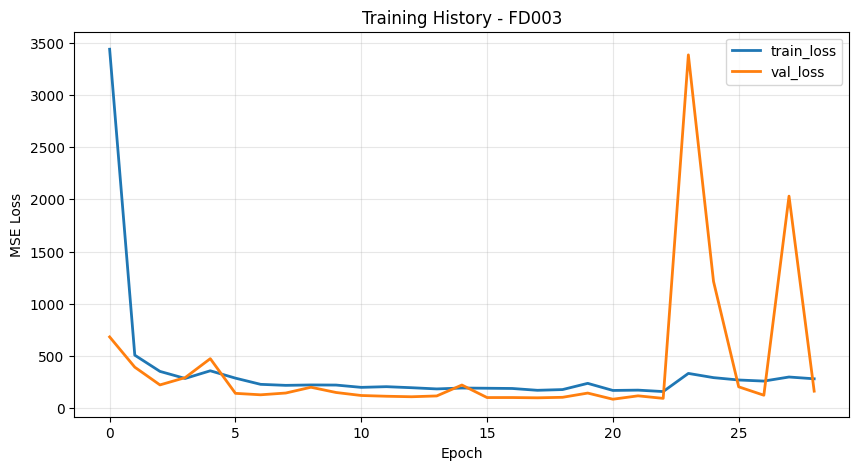

In [12]:
# Cell 10: Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="train_loss", linewidth=2)
plt.plot(history.history["val_loss"], label="val_loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training History - FD003")
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
# Cell 11: Evaluate on validation set
y_val_pred = model.predict(X_val, verbose=0).ravel()
rmse_val = math.sqrt(mean_squared_error(y_val, y_val_pred))
mae_val = np.mean(np.abs(y_val - y_val_pred))

print(f"Validation RMSE: {rmse_val:.4f}")
print(f"Validation MAE: {mae_val:.4f}")

Validation RMSE: 9.2355
Validation MAE: 6.5380


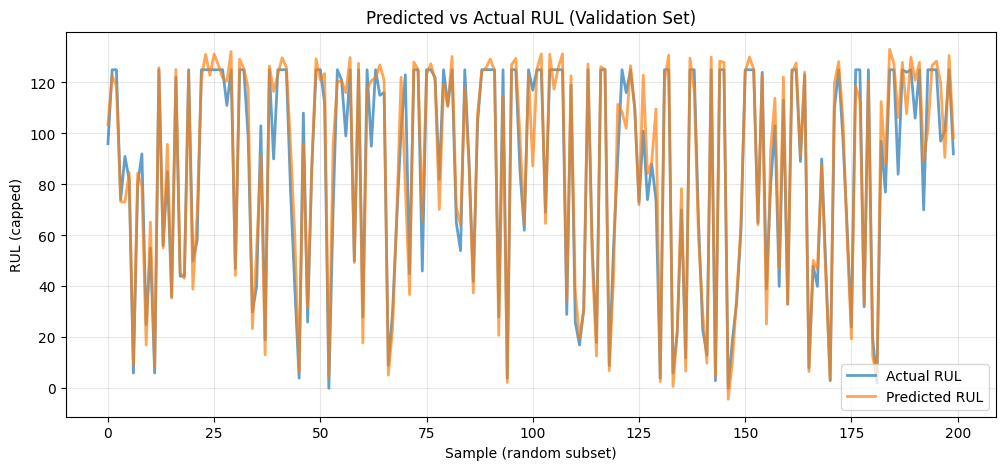

In [14]:
# Cell 12: Predicted vs Actual plot (random sample)
sample_size = min(200, len(y_val))
idx = np.random.choice(len(y_val), size=sample_size, replace=False)

plt.figure(figsize=(12, 5))
plt.plot(y_val[idx], label="Actual RUL", linewidth=2, alpha=0.7)
plt.plot(y_val_pred[idx], label="Predicted RUL", linewidth=2, alpha=0.7)
plt.xlabel("Sample (random subset)")
plt.ylabel("RUL (capped)")
plt.legend()
plt.title("Predicted vs Actual RUL (Validation Set)")
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
# Cell 13: Test set evaluation (if test files exist)
if os.path.exists(test_file) and os.path.exists(rul_file):
    print("Loading test data...")
    
    # Read test data
    df_test_raw = read_cmapss(test_file)
    
    # Preprocess test data using the fitted scaler
    df_test_scaled = df_test_raw.copy()
    df_test_scaled[sensor_cols] = scaler.transform(df_test_raw[sensor_cols].values)
    
    # Build test sequences: use last SEQ_LEN cycles for each unit
    X_test = []
    test_units = sorted(df_test_scaled["unit"].unique())
    
    for u in test_units:
        tmp = df_test_scaled[df_test_scaled["unit"] == u].sort_values("cycle")
        arr = tmp[sensor_cols].values
        
        if arr.shape[0] >= SEQ_LEN:
            X_test.append(arr[-SEQ_LEN:])
        else:
            # Pad at front if not enough cycles
            pad_n = SEQ_LEN - arr.shape[0]
            pad = np.tile(arr[0], (pad_n, 1))
            X_test.append(np.vstack([pad, arr]))
    
    X_test = np.array(X_test)
    
    # Load true RUL values
    y_test_true = pd.read_csv(rul_file, sep=r"\s+", header=None).values.ravel()
    
    # Cap RUL the same way as training
    CAP_RUL = 125
    y_test_true = np.clip(y_test_true, a_min=None, a_max=CAP_RUL)
    
    # Make predictions
    y_test_pred = model.predict(X_test, verbose=0).ravel()
    
    # Evaluate
    rmse_test = math.sqrt(mean_squared_error(y_test_true, y_test_pred))
    mae_test = np.mean(np.abs(y_test_true - y_test_pred))
    
    print(f"\nTest RMSE (capped at {CAP_RUL}): {rmse_test:.4f}")
    print(f"Test MAE: {mae_test:.4f}")
    print(f"Test samples: {len(y_test_true)}")
else:
    print("Test files not found!")

Loading test data...


c:\Users\Sneha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Test RMSE (capped at 125): 13.5335
Test MAE: 9.3243
Test samples: 100


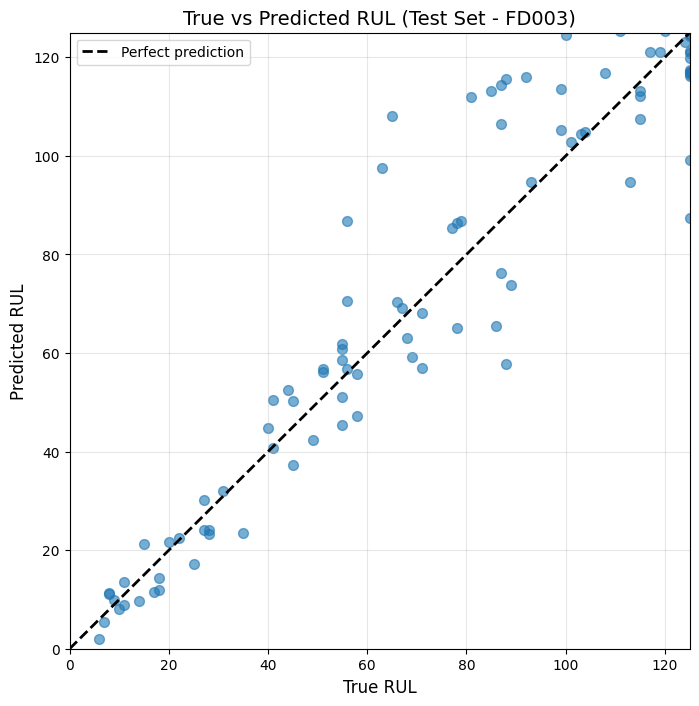

In [16]:
# Cell 14: Test set scatter plot (True vs Predicted)
if os.path.exists(test_file) and os.path.exists(rul_file):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test_true, y_test_pred, alpha=0.6, s=50)
    plt.xlabel("True RUL", fontsize=12)
    plt.ylabel("Predicted RUL", fontsize=12)
    plt.title("True vs Predicted RUL (Test Set - FD003)", fontsize=14)
    plt.plot([0, CAP_RUL], [0, CAP_RUL], "k--", linewidth=2, label="Perfect prediction")
    plt.xlim(0, CAP_RUL)
    plt.ylim(0, CAP_RUL)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Test files not available for visualization")

In [17]:
# Cell 15: Health status alerts for test units
if os.path.exists(test_file) and os.path.exists(rul_file):
    WARNING_THRESHOLD = 30
    CRITICAL_THRESHOLD = 10
    
    def get_alert_status(rul_value):
        """Determine health status based on RUL prediction."""
        if rul_value <= CRITICAL_THRESHOLD:
            return "CRITICAL ⚠️"
        elif rul_value <= WARNING_THRESHOLD:
            return "WARNING ⚠"
        else:
            return "NORMAL ✓"
    
    print("\n" + "="*80)
    print("HEALTH STATUS ALERTS FOR TEST UNITS (FD003)")
    print("="*80)
    print(f"{'Unit':<8} {'True RUL':<12} {'Pred RUL':<12} {'Error':<12} {'Status':<20}")
    print("-"*80)
    
    for i in range(len(test_units)):
        error = abs(y_test_true[i] - y_test_pred[i])
        status = get_alert_status(y_test_pred[i])
        print(f"{test_units[i]:<8} {y_test_true[i]:<12.2f} {y_test_pred[i]:<12.2f} {error:<12.2f} {status:<20}")
    
    print("="*80)
else:
    print("Test files not available for alerts")


HEALTH STATUS ALERTS FOR TEST UNITS (FD003)
Unit     True RUL     Pred RUL     Error        Status              
--------------------------------------------------------------------------------
1        44.00        52.54        8.54         NORMAL ✓            
2        51.00        56.71        5.71         NORMAL ✓            
3        27.00        30.18        3.18         NORMAL ✓            
4        120.00       125.42       5.42         NORMAL ✓            
5        101.00       102.91       1.91         NORMAL ✓            
6        99.00        113.53       14.53        NORMAL ✓            
7        71.00        57.00        14.00        NORMAL ✓            
8        55.00        61.80        6.80         NORMAL ✓            
9        55.00        51.03        3.97         NORMAL ✓            
10       66.00        70.27        4.27         NORMAL ✓            
11       77.00        85.28        8.28         NORMAL ✓            
12       115.00       107.44       7.56       